# Cell Segmentation
```{eval-rst}
Last updated |lastupdate|
```

In this section we will build a model to perform cell segmentation on phase contrast images. You can learn more about the model architecture used in this notebook in {doc}`spot-detection`.

[![Open in Colab](https://img.shields.io/static/v1?logo=google-colab&message=Open%20in%20colab&color=blue&label=%20&labelColor=5c5c5c)](https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/segmentation.ipynb)

In [ ]:
# Install the latest version of DeepCell
!pip install "deepcell==0.9.0"

In [1]:
import deepcell
import numpy as np
import matplotlib.pyplot as plt

## Load the data

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.

Here we create a few `Dataset` objects based on existing S3 files. Then we can use the `load_data()` function to load and split the training data. `test_size` is used to adjust the share of data reserved for testing and `seed` is used to generate the random train-test split.

In [2]:
base_url = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
            'demos/janelia/hela_s3_{}_256.npz')

dataset = deepcell.datasets.Dataset(
    path='phase.npz',
    url=base_url.format('phase'),
    file_hash='c56df51039fe6cae15c818118dfb8ce8',
    metadata=None
)

test_size = 0.2 # fraction of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = dataset.load_data(
    test_size=test_size, seed=seed)

print('X_train.shape: {}\nX_test.shape: {}'.format(
    X_train.shape, X_test.shape))

X_train.shape: (1872, 256, 256, 1)
X_test.shape: (468, 256, 256, 1)


In order to segment cells from phase images, we will predict three transformations of the images. The figure below shows the raw data and ground truth masks in the first column. The second column shows the first transformation, foreground/background, which has two classes. The third column shows the two watershed transformations: inner distance and outer distance.

Text(0.5, 1.0, 'Outer Distance')

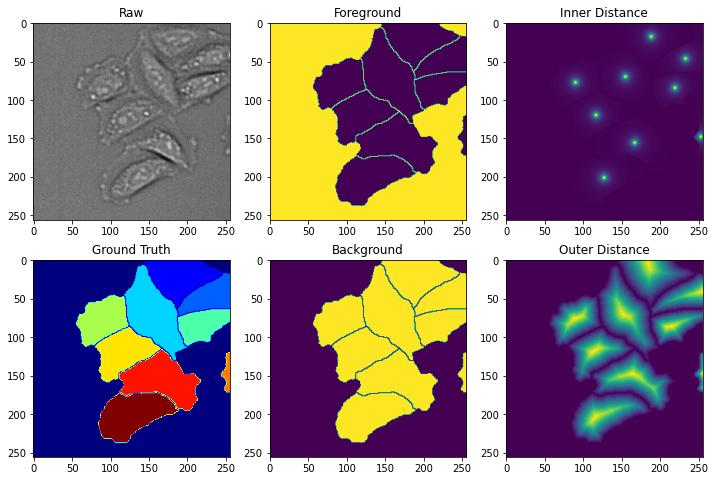

In [3]:
from deepcell.image_generators import _transform_masks

i = 400
im = X_train[i:i+1]
mask = y_train[i:i+1]
fgbg = _transform_masks(mask,'fgbg')
inner = _transform_masks(mask,'inner_distance')
outer = _transform_masks(mask,'outer_distance',erosion_distance=0)

fig,ax = plt.subplots(2,3,figsize=(12,8))

ax[0,0].imshow(np.squeeze(im),cmap='gray')
ax[0,0].set_title('Raw')
ax[1,0].imshow(np.squeeze(mask),cmap='jet')
ax[1,0].set_title('Ground Truth')

ax[0,1].imshow(fgbg[0,...,0])
ax[0,1].set_title('Foreground')
ax[1,1].imshow(fgbg[0,...,1])
ax[1,1].set_title('Background')

ax[0,2].imshow(np.squeeze(inner))
ax[0,2].set_title('Inner Distance')
ax[1,2].imshow(np.squeeze(outer))
ax[1,2].set_title('Outer Distance')

## Create the PanopticNet Model

Since we are predicting three different transforms of the data, we instantiate a PanopticNet model from `deepcell.model_zoo` using 3 semantic heads, one for each transform:

* inner distance (1 class)
* outer distance (1 class)
* foreground/background (2 classes)

In [4]:
from deepcell.model_zoo.panopticnet import PanopticNet

semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    include_top=True,
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

## Prepare for training

### Setting up training parameters

There are a number of tunable hyper parameters necessary for training deep learning models:

**backbone**: The majority of DeepCell models support a variety backbone choices specified in the "backbone" parameter. Backbones are provided through `tf.keras.applications` and can be instantiated with weights that are pretrained on ImageNet. Other valid backbones include `vgg16`, `vgg19`, `mobilenetv2`, `nasnet_large`, and `nasnet_mobile`.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model weights after each batch.

**optimizer**: "Optimizers" are algorithms that are used to update the model weights to minimize the loss function. The TensorFlow module `tf.keras.optimizers` offers optimizers with a variety of algorithm implementations. DeepCell typically uses the [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) or the [`SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

**min_objects**: Only trains on images with at least this many instances.

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 5

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

min_objects = 2

### Create the DataGenerators

The SemanticDataGenerator can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use "inner-distance", "outer-distance" and "fgbg" to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a dict of transform names to kwargs.

In [6]:
from deepcell import image_generators

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

Now that our datasets are set up, we can call `train_data.next()` to check the output, which should match what we looked at in the previous figure.

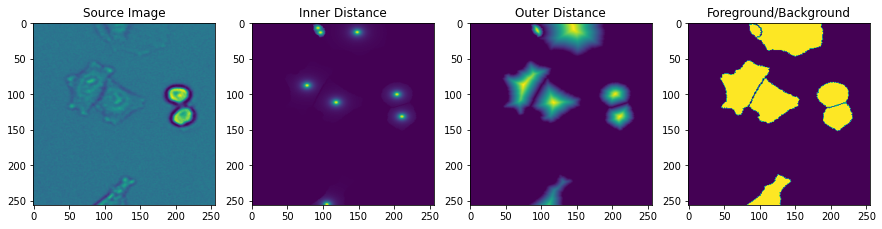

In [7]:
inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 1])
axes[3].set_title('Foreground/Background')

plt.show()

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.


In [8]:
# Create a dictionary of losses for each semantic head
from tensorflow.keras.losses import MSE
from deepcell.losses import weighted_categorical_crossentropy


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [9]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `model.fit()` on the compiled model, with a default set of callbacks.


In [10]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_name = 'phase_deep_watershed'
model_path = '{}.h5'.format(model_name)

print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
234/234 [==============================] - 132s 491ms/step - loss: 0.2044 - semantic_0_loss: 0.0081 - semantic_1_loss: 0.1931 - semantic_2_loss: 0.0032 - val_loss: 0.1349 - val_semantic_0_loss: 0.0045 - val_semantic_1_loss: 0.0618 - val_semantic_2_loss: 0.0686

Epoch 00001: val_loss improved from inf to 0.13486, saving model to phase_deep_watershed.h5
Epoch 2/5
234/234 [==============================] - 113s 482ms/step - loss: 0.0108 - semantic_0_loss: 0.0024 - semantic_1_loss: 0.0074 - semantic_2_loss: 0.0010 - val_loss: 0.0502 - val_semantic_0_loss: 0.0045 - val_semantic_1_loss: 0.0365 - val_semantic_2_loss: 0.0092

Epoch 00002: val_loss improved from 0.13486 to 0.05022, saving model to phase_deep_watershed.h5
Epoch 3/5
234/234 [==============================] - 113s 480ms/step - loss: 0.0133 - semantic_0_loss: 0.0025 - semantic_1_loss: 0.0098 - semantic_2_loss: 9.0433e-04 - val_loss: 0.0126 - val_semantic_0_loss: 0.0024 - val_semantic_1_loss: 0.0084 - v


## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.


In [11]:
from deepcell.model_zoo.panopticnet import PanopticNet

prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape=X_train.shape[1:]
)

In [12]:
prediction_model.load_weights(model_path, by_name=True)

In [13]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape,
      'in', watershed_time, 'seconds.')

Watershed segmentation of shape (468, 256, 256, 1) in 4.933405328003573 seconds.


Now that we have predictions stored in `test_images`, we can import a post-processing function from `deepcell_toolbox` to transform the predictions into an instance mask.

155


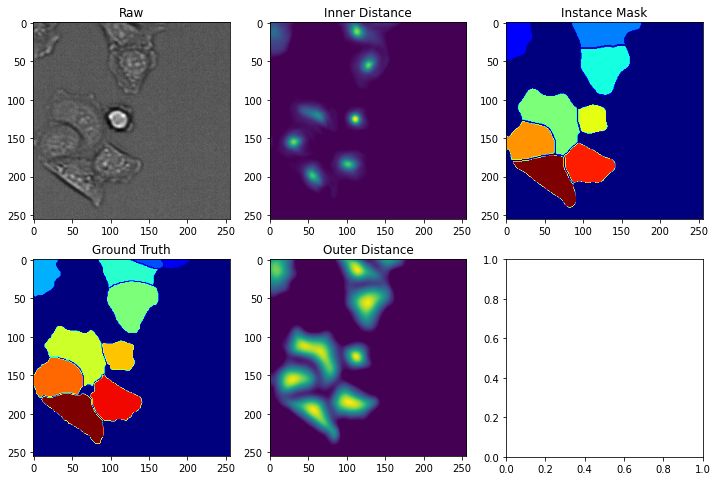

In [14]:
import random

from deepcell_toolbox.deep_watershed import deep_watershed

index = random.randint(0, X_test.shape[0])
print(index)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

# raw image with centroid
axes[0,0].imshow(X_test[index, ..., 0], cmap='gray')
axes[0,0].set_title('Raw')
axes[1,0].imshow(y_test[index,...,0], cmap='jet')
axes[1,0].set_title('Ground Truth')

axes[0,1].imshow(inner_distance[index, ..., 0])
axes[0,1].set_title('Inner Distance')
axes[1,1].imshow(outer_distance[index, ..., 0])
axes[1,1].set_title('Outer Distance')

axes[0,2].imshow(masks[index, ...], cmap='jet')
axes[0,2].set_title('Instance Mask')

plt.show()

## Evaluate results

The `deepcell.metrics` package is used to measure advanced metrics for instance segmentation predictions. Below we will primarily focus on _recall_ and _precision_.

**recall**: The fraction of the total amount of instances that were actually detected. ( TP / (TP + FN) )

**precision**: The fraction of instances among the detected instances. ( TP / (TP + FP) )

In [15]:
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import clear_border
from deepcell.metrics import Metrics

y_pred = np.expand_dims(masks.copy(), axis=-1)
y_true = y_test.copy()

m = Metrics('DeepWatershed - Remove no pixels', seg=False)
m.calc_object_stats(y_true, y_pred)


____________Object-based statistics____________

Number of true cells:		 4727
Number of predicted cells:	 4140

Correct detections:  3922	Recall: 82.9702%
Incorrect detections: 218	Precision: 94.7343%

Gained detections: 74	Perc Error: 9.0686%
Missed detections: 654	Perc Error: 80.1471%
Merges: 38		Perc Error: 4.6569%
Splits: 32		Perc Error: 3.9216%
Catastrophes: 18		Perc Error: 2.2059%

Gained detections from splits: 33
Missed detections from merges: 41
True detections involved in catastrophes: 40
Predicted detections involved in catastrophes: 41 

Average Pixel IOU (Jaccard Index): 0.8863 



In [16]:
%load_ext watermark
%watermark -u -d -vm --iversions

deepcell 0.9.0
numpy    1.19.5
last updated: 2021-04-27 

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-142-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 24
interpreter: 64bit
